<a href="https://colab.research.google.com/github/ds4geo/ds4geo/blob/master/WS%202020%20Course%20Notes/Session%209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science for Geoscientists - Winter Semester 2020**
# **Session 9 - Supervised Machine Learning - 2nd December 2020**

This week we will use two supervised machine learning techniques to try and classify rock types based on their bulk chemistry. We will use the traditional random forest method, and a simple neural network.

# 9.1 Introduction to Supervised Machine Learning
* Learning classification or regression from data with labels
* Aim to learn general rules which can be applied on other data
* Many algorithms are black boxes - the "rules" are difficult or impossible to know or understand

* examples


# 9.2 Introduction to rock geochem database
To try out some supervised ML, we use the rock geochemistry database published here:
https://essd.copernicus.org/articles/11/1553/2019/essd-11-1553-2019.pdf

We will try to use ML to predict the rock types based on the bulk chemistry.
I've already prepared and cleaned a subset of the data containing about 300,000 rock samples with rock names (top 14 only) and major element data:

https://github.com/ds4geo/ds4geo/blob/master/data/unordered/gwrgdb_maj_ele.csv?raw=true

## Inspecting the data
Below we:
* Load the data
* Do some simple visualisations
* Perform PCA analysis and standardisation

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [51]:
dat = pd.read_csv("https://github.com/ds4geo/ds4geo/blob/master/data/unordered/gwrgdb_maj_ele.csv?raw=true")

In [52]:
dat.rock_name.value_counts()

basalt                128307
andesite               35792
rhyolite               28238
granite                24589
dacite                 17783
gabbro                 13118
granodiorite           12580
andesite  basaltic     10637
tholeiite              10388
gneiss                  6443
sandstone               5314
siliciclastic           4377
biogenic                1427
carbonate               1216
Name: rock_name, dtype: int64

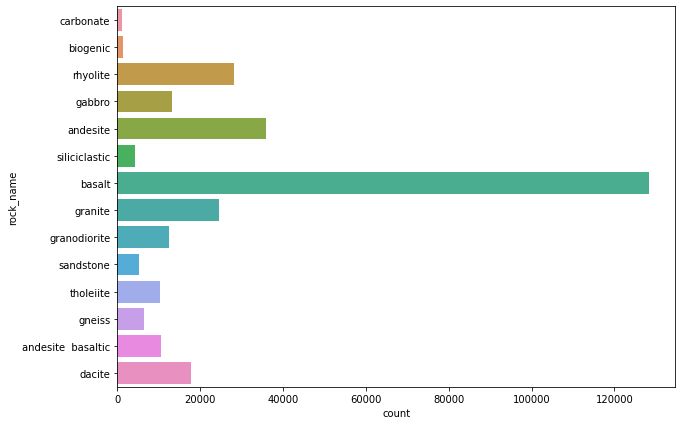

In [53]:
# 
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=dat, y="rock_name")

In [54]:
dat

,rock_name,sio2,tio2,al2o3,cr2o3,fe2o3,feo,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,caco3,mgco3
0,carbonate,-0.133058,0.004258,0.040159,0.0,0.080270,0.00,0.491735,56.256725,0.001645,0.0,0.004645,0.025499,0.027725,0.000000,0.0,0
1,carbonate,-0.125000,0.009961,0.237194,0.0,0.150941,0.00,0.711252,55.468255,0.008428,0.0,-0.030101,0.005692,0.252736,0.033822,0.0,0
2,carbonate,-0.074878,0.004110,0.017141,0.0,0.196467,0.00,0.422455,56.301081,0.001804,0.0,0.008370,0.026964,0.022554,0.000000,0.0,0
3,carbonate,-0.072379,0.004258,0.012973,0.0,0.066819,0.00,0.781940,55.908111,0.000000,0.0,0.001252,0.033660,0.036715,0.000000,0.0,0
4,carbonate,-0.041508,0.004052,0.017542,0.0,0.070118,0.00,0.438004,56.313090,0.001038,0.0,0.012650,0.041112,0.025843,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300204,basalt,99.600000,0.030000,0.200000,0.0,0.000000,0.04,0.000000,0.000000,0.000000,0.0,0.020000,0.000000,0.000000,0.000000,0.0,0
300205,sandstone,99.600000,0.000000,0.000000,0.0,0.560000,0.21,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0
300206,sandstone,99.800000,0.040000,0.440000,0.0,0.000000,0.00,0.050000,0.110000,0.000000,0.0,0.000000,0.020000,0.000000,0.030000,0.0,0
300207,sandstone,99.990000,0.010000,0.100000,0.0,0.000000,0.00,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0


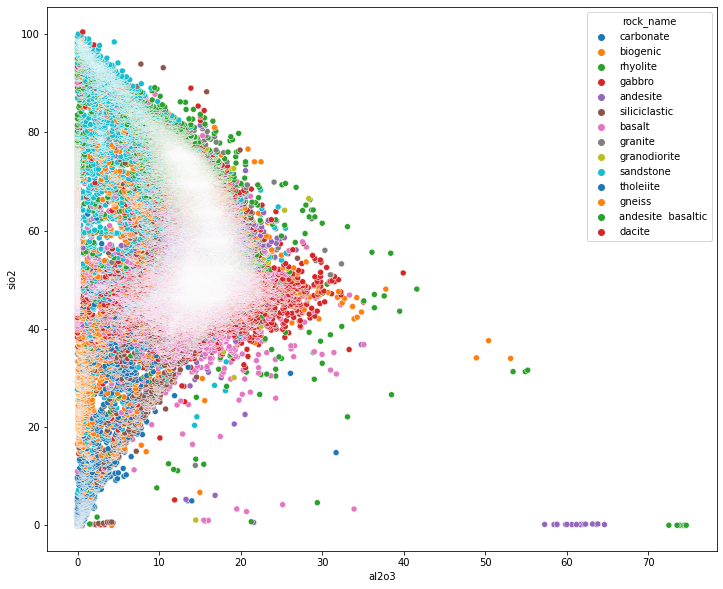

In [55]:
# Plot Al vs Si as scatter plot
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=dat, x="al2o3", y="sio2", hue="rock_name", ax=ax, palette="tab10")

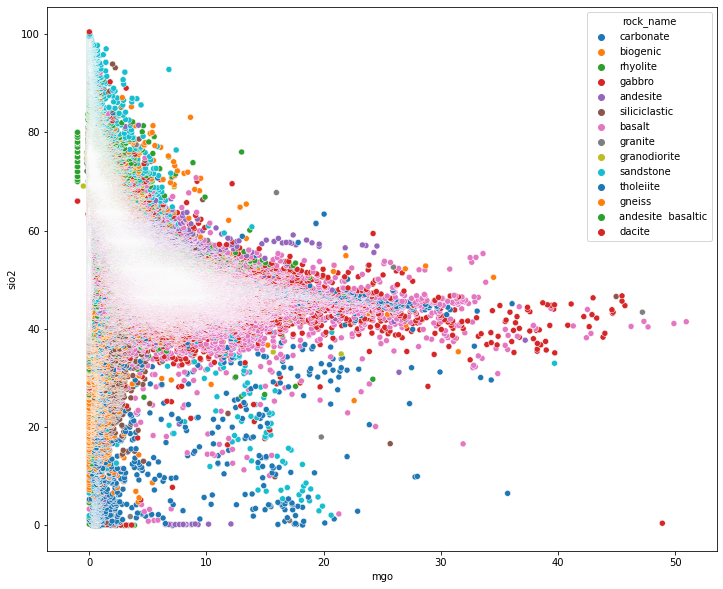

In [56]:
# Plot Mg vs Si as scatter plot
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=dat, x="mgo", y="sio2", hue="rock_name", ax=ax, palette="tab10")

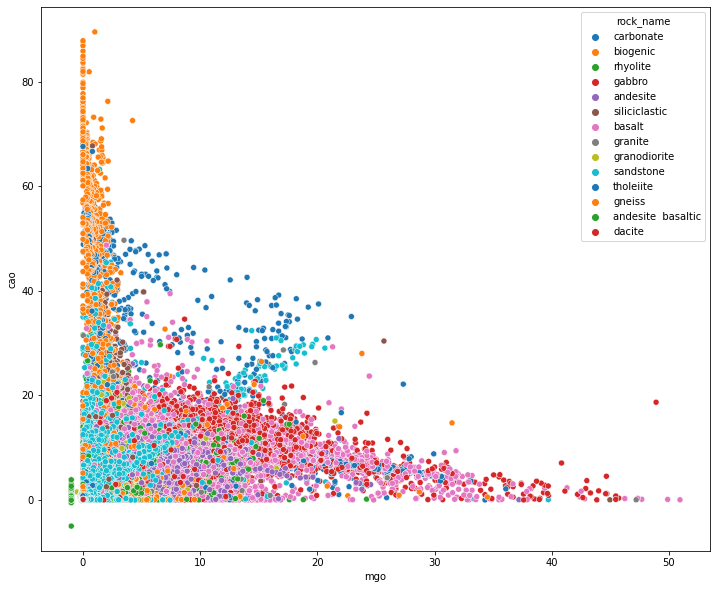

In [57]:
# Plot Mg vs Ca as scatter plot
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=dat, x="mgo", y="cao", hue="rock_name", ax=ax, palette="tab10")

In [58]:
# We'll want to standardise the data
from sklearn.preprocessing import StandardScaler

In [59]:
# Standardize
rdat = dat.iloc[:,1:]
sdat = StandardScaler().fit_transform(X=rdat)
sdat = pd.DataFrame(sdat, index=rdat.index, columns=rdat.columns)
sdat

,sio2,tio2,al2o3,cr2o3,fe2o3,feo,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,caco3,mgco3
0,-5.263409,-1.202817,-4.369917,-0.023153,-0.482811,-0.728177,-1.144038,9.029833,-0.324024,-0.005566,-0.996835,-2.400019,22.297611,-0.347074,-0.045236,0.0
1,-5.262670,-1.196729,-4.310732,-0.023153,-0.461181,-0.728177,-1.082226,8.884681,-0.308656,-0.005566,-1.016681,-2.416301,203.398980,-0.294095,-0.045236,0.0
2,-5.258067,-1.202975,-4.376831,-0.023153,-0.447248,-0.728177,-1.163547,9.037999,-0.323664,-0.005566,-0.994708,-2.398814,18.135827,-0.347074,-0.045236,0.0
3,-5.257838,-1.202818,-4.378083,-0.023153,-0.486928,-0.728177,-1.062321,8.965656,-0.327752,-0.005566,-0.998773,-2.393310,29.533851,-0.347074,-0.045236,0.0
4,-5.255003,-1.203037,-4.376710,-0.023153,-0.485918,-0.728177,-1.159168,9.040209,-0.325400,-0.005566,-0.992263,-2.387184,20.783616,-0.347074,-0.045236,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300204,3.894203,-1.175336,-4.321904,-0.023153,-0.507378,-0.718464,-1.282504,-1.326648,-0.327752,-0.005566,-0.988065,-2.420980,-0.016534,-0.347074,-0.045236,0.0
300205,3.894203,-1.207363,-4.381980,-0.023153,-0.335986,-0.677183,-1.282504,-1.326648,-0.327752,-0.005566,-0.999488,-2.420980,-0.016534,-0.347074,-0.045236,0.0
300206,3.912567,-1.164660,-4.249813,-0.023153,-0.507378,-0.728177,-1.268425,-1.306398,-0.327752,-0.005566,-0.999488,-2.404539,-0.016534,-0.300082,-0.045236,0.0
300207,3.930013,-1.196687,-4.351942,-0.023153,-0.507378,-0.728177,-1.271241,-1.326648,-0.327752,-0.005566,-0.999488,-2.420980,-0.016534,-0.347074,-0.045236,0.0


In [60]:
# Lets do a PCA to see if there's clear structure
from sklearn.decomposition import PCA

In [61]:
pca = PCA()
pca.fit(sdat)

pdat = pca.transform(sdat)
pdat = pd.DataFrame(pdat, index=sdat.index)
evr = pca.explained_variance_ratio_

In [62]:
from sklearn import preprocessing
# convert rock names to integer labels - necessary later for classification
le = preprocessing.LabelEncoder()
y = le.fit_transform(dat.rock_name)

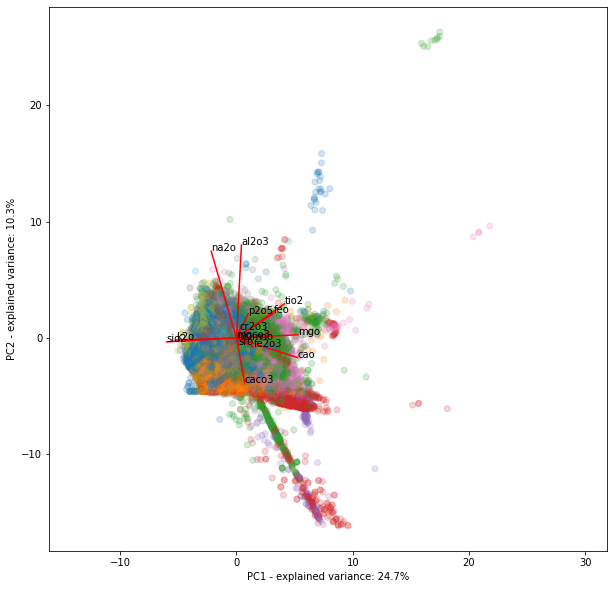

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
pc2plot = (1,2)
ax.scatter(pdat.loc[:, pc2plot[0]-1], pdat.loc[:, pc2plot[1]-1], alpha=0.2, c=["C{}".format(j) for j in y])
ax.axis('equal')
ax.set_xlabel("PC{} - explained variance: {}%".format(pc2plot[0], round(evr[pc2plot[0]-1]*100,1)))
ax.set_ylabel("PC{} - explained variance: {}%".format(pc2plot[1], round(evr[pc2plot[1]-1]*100,1)))

for v, nm in zip(pca.components_[[np.array(pc2plot)-1],:].T, sdat.columns):
  vec = v * 12.5
  ax.plot([0,vec[0]], [0, vec[1]],"r")
  ax.text(vec[0],vec[1], nm)

# 9.3 Machine Learning Algorithms: Random Forest
Here we try out a common machine learning classification method: random forest, and explain shortly how it works.

## ML models in python
At simplest, all these algorithms have the same usage style in python:

In [64]:
# We'll discuss this step later
from sklearn import model_selection
xt, xv, yt, yv = model_selection.train_test_split(sdat,y, test_size=0.2)

In [65]:
from sklearn.ensemble import RandomForestClassifier
# create the model - we'll discuss the parameters later
clf = RandomForestClassifier(max_depth=15, random_state=0, verbose=1, n_jobs=5)

# train the model on input data and corresponding labels
# This step takes some minutes, so we'll let it run while we continue with the explanations
clf.fit(xt, yt)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   47.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [68]:
# Score the model to assess its accuracy
clf.score(xt, yt)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.7s finished


0.8267164098314923

In [67]:
# Use the model for prediction
clf.predict(xv)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.3s finished


array([ 2,  2, 10, ...,  2,  0,  2])

## Theory: Decision Trees and Random Forest
* Decision trees for classification
 * A hierarchical set of rules to classify from attributes/data

 * Rock classification example:
![](https://www.vagabondgeology.com/uploads/3/4/1/2/3412046/2367852.jpg?895)

  * Can be learnt from the data itself
  * Start with the feature/attribute which best splits the data

* Generalisation and the problem of overfitting
 * Aim is to learn the general patterns from the data
 * But ML models can end up simply memorising the training data, not learning the general patterns
 * This is overfitting
 * Decision trees are very prone to overfitting
* The solution: Random Forest
 * An ensemble of a large number of deliberately imperfect decision trees.
 * Randomly pick features/attributes at each level of the tree
 * Average results of all the decision trees in the forest

## Train, Validate, Test
Because ML models should learn general patterns from the data, its important to see how they perform on data which they do not train on. Standard practice is to split the available data into 2-3 groups:
1. Training data - data the model directly uses while learning.
2. Validation data - data the model uses periodically to test its own performance, but which isn't seen while learning.
3. Test data - the gold standard - data which the model has never even indirectly interacted with which provides a completely unbiased assessment of its performance.

See above: train_test_split()

Below we compare the performance of our model on the training and validation data.

In [69]:
clf.verbose = False # turn off progress messages

In [70]:
print("train score:", round(clf.score(xt, yt)*100,1),"%")
print("test score:", round(clf.score(xv, yv)*100,1),"%")

train score: 82.7 %
test score: 75.4 %


We can see that the model performs much better on the training data than the test data, but that it performs well on both!

This is an indication of slight overfitting. Dramatic overfitting can occur when train scores are very high (approaching 100%) but test scores approach 0%.

## Model hyperparameters
ML models have parameters which define their properties which depend on the type of model.
For random forest, two key parameters are:
1. The number of trees in the forest (n_estimators)- how large the ensemble is
2. The maximum tree depth (max_depth) - how many levels of decision can occur per tree

The above example used 100 trees (the default) and a maximum tree depth of 15.
Below we try some other combinations:

In [71]:
# 15 trees with max depth of 5
clf_small = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0, verbose=1, n_jobs=5)
clf_small.fit(xt, yt)
print("train score:", round(clf_small.score(xt, yt)*100,1),"%")
print("test score:", round(clf_small.score(xv, yv)*100,1),"%")
# result very fast (only a few seconds), but much lower accuracy

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.1s finished


train score: 66.3 %
test score: 66.1 %


In [72]:
# 50 trees with max depth of 5
clf_med1 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=1, n_jobs=5)
clf_med1.fit(xt, yt)
print("train score:", round(clf_med1.score(xt, yt)*100,1),"%")
print("test score:", round(clf_med1.score(xv, yv)*100,1),"%")
# More trees didn't help accuracies, but took much longer

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    9.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    1.1s finished


train score: 66.0 %


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


test score: 65.9 %


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    0.3s finished


In [73]:
# 10 trees with max depth of 15
clf_med2 = RandomForestClassifier(n_estimators=10, max_depth=15, random_state=0, verbose=1, n_jobs=5)
clf_med2.fit(xt, yt)
print("train score:", round(clf_med2.score(xt, yt)*100,1),"%")
print("test score:", round(clf_med2.score(xv, yv)*100,1),"%")
# Maximum depth seems to help accuracies a lot more, even with fewer trees, making it faster than the original case!

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.1s finished


train score: 81.8 %
test score: 74.5 %


In [74]:
# 10 trees with max depth of 25
clf_med2 = RandomForestClassifier(n_estimators=10, max_depth=25, random_state=0, verbose=1, n_jobs=5)
clf_med2.fit(xt, yt)
print("train score:", round(clf_med2.score(xt, yt)*100,1),"%")
print("test score:", round(clf_med2.score(xv, yv)*100,1),"%")
# Increasing maximum depth even with few estimators increases the test score, but more (but not bad) overfitting!

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


train score: 96.9 %
test score: 76.2 %


[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.2s finished


## Assessing the Model Performance - Confusion Matrix
Assessing ML model performance is itself a huge topic, but one useful approach is the confusion matrix. It compares all possible combinations of true categories and predicted categories. Correct classifications are on the diagonal. It is valuable for seeing which categories the model struggles to classify.

Fortunately, sklearn provides a very easy all-in-one function to make confusion matrix plots.

Given the list of rock types, which confusions do you expect?

In [75]:
print(le.classes_)

['andesite' 'andesite  basaltic' 'basalt' 'biogenic' 'carbonate' 'dacite'
 'gabbro' 'gneiss' 'granite' 'granodiorite' 'rhyolite' 'sandstone'
 'siliciclastic' 'tholeiite']


In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix()

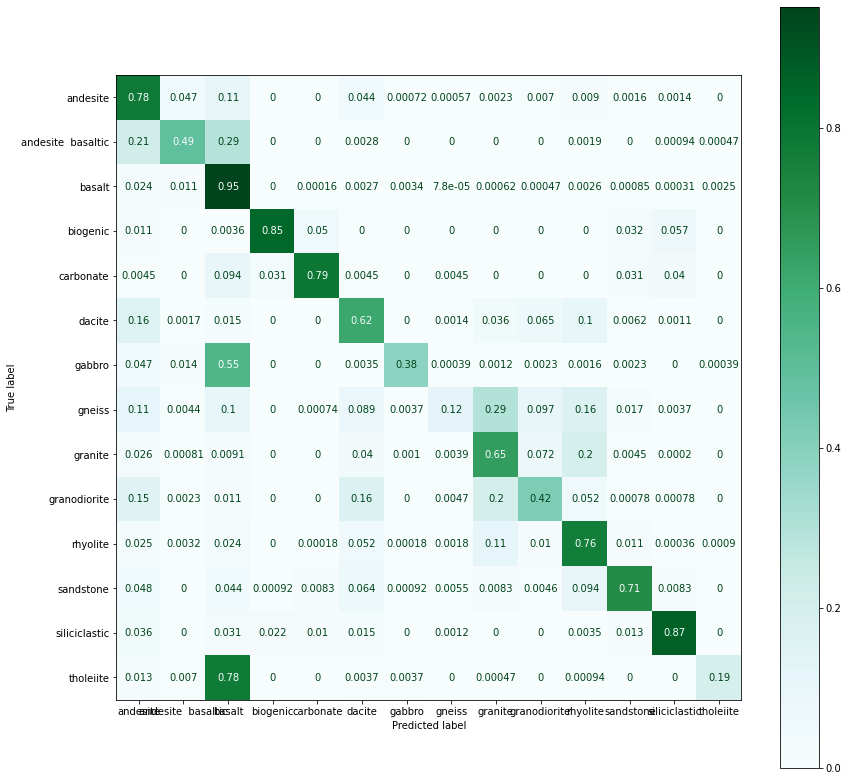

In [79]:
fig, ax = plt.subplots(figsize=(14,14))
plot_confusion_matrix(clf, xv, yv, normalize="true", display_labels=le.classes_, ax=ax, cmap="BuGn")


## Hyper parameter search
It is common practice to automatically test different hyperparameter combinations to find a set which produce the most accurate model.
We try a simple search here just on the max_depth parameter.

In [80]:
# import helpful progress bar library
from tqdm.notebook import tqdm

In [81]:
train_score = []
val_score = []
depth = []
for j in tqdm(range(5,41,5)):
    depth.append(j)
    
    clf = RandomForestClassifier(n_estimators=5, max_depth=j, random_state=0, verbose=0, n_jobs=8)
    clf.fit(xt, yt)
    
    train_score.append(clf.score(xt, yt))
    val_score.append(clf.score(xv, yv))



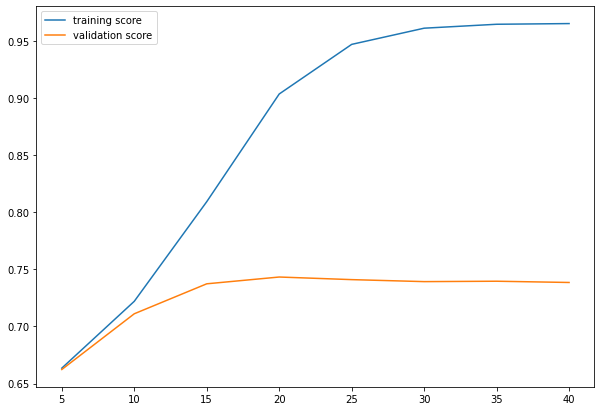

In [82]:
# Compare the scores vs tree depths
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(depth, train_score, label="training score")
ax.plot(depth, val_score, label="validation score")
ax.legend()

In [83]:
train_score2 = []
val_score2 = []
depth2 = []
for j in tqdm(range(5,41,5)):
    depth2.append(j)
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=j, random_state=0, verbose=0, n_jobs=8)
    clf.fit(xt, yt)
    
    train_score2.append(clf.score(xt, yt))
    val_score2.append(clf.score(xv, yv))



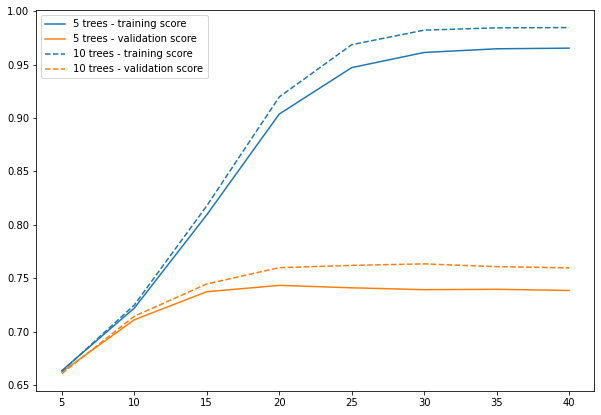

In [87]:
# Compare the scores vs tree depths
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(depth, train_score, label="5 trees - training score", color = "C0", ls ="-")
ax.plot(depth, val_score, label="5 trees - validation score", color = "C1", ls="-")

ax.plot(depth2, train_score2, label="10 trees - training score", color = "C0", ls="--")
ax.plot(depth2, val_score2, label="10 trees - validation score", color = "C1", ls="--")

ax.legend()

## Feature importance

In [91]:
for imp, rock in zip(clf.feature_importances_, sdat.columns):
  print(rock,":", round(imp*100,1),"%")

sio2 : 18.7 %
tio2 : 10.4 %
al2o3 : 8.0 %
cr2o3 : 0.3 %
fe2o3 : 3.8 %
feo : 5.4 %
mgo : 11.5 %
cao : 13.9 %
mno : 6.9 %
nio : 0.0 %
k2o : 7.5 %
na2o : 7.9 %
sro : 0.0 %
p2o5 : 5.5 %
caco3 : 0.1 %
mgco3 : 0.0 %


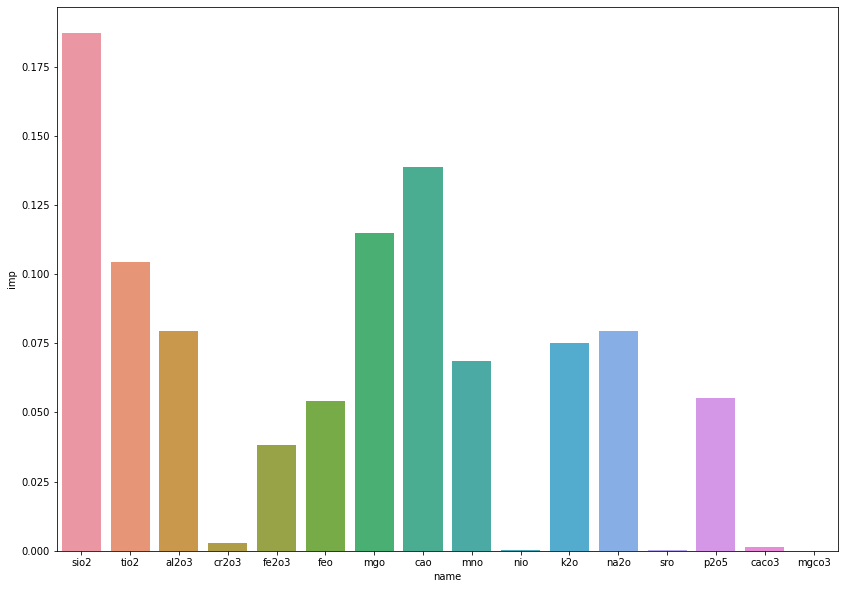

In [98]:
impdat = pd.DataFrame({"imp": clf.feature_importances_, "name": sdat.columns})
impdat
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(data=impdat, x = "name", y = "imp", ax=ax)

# 9.4 Neural Networks and Deep Learning

![](https://imgs.xkcd.com/comics/machine_learning.png)

Neural networks are ML models designed to work analogously to neurons in the brain. Each neuron is connected to every neuron in the layer before and the layer after and each connection has a weighting.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Neural_network_example.svg/1200px-Neural_network_example.svg.png"  height="600" />


In the simplest possible terms, a neural network learns by randomly changing all of the weights, seeing if the output is closer or further away from the true data (i.e. the labels), and iteratively refining these weights until the learning doesn't improve further.

We will discuss in class more next week, but please watch the following videos to understand the general concepts:
A really light introduction (note, the "infinite classrom" learning approach here isn't a good analogy for the actual way neural networks usually learn, but it is a helpful concept to understand anyway):
https://www.youtube.com/watch?v=R9OHn5ZF4Uo

A footnote to the above video which very lightly introduces the real way neural networks learn:
https://www.youtube.com/watch?v=wvWpdrfoEv0

Taking a serious but excellent step into what is really going on:
https://www.youtube.com/watch?v=aircAruvnKk
See also the follow-up videos in that series.


sklearn makes it very easy to switch different ML models, so we can try using a deep neural network with very few changes, and leave greater understanding of what is really going on for next week.

First we replicate the original Random Forest example as closely as possible.

Note, during training, if we set verbose=1, we see the "loss" of the model for each iteration of training. The loss is a measure of model performance like accuracy, but where lower is better. Many loss functions are available depending on the data and problem.

In [99]:
from sklearn.neural_network import MLPClassifier

In [100]:
mlp = MLPClassifier(hidden_layer_sizes=(32), verbose=1, max_iter=50)
mlp.fit(xt, yt)

print("train score:", mlp.score(xt, yt))
print("test score:", mlp.score(xv, yv))

Iteration 1, loss = 1.23471035
Iteration 2, loss = 1.01135758
Iteration 3, loss = 0.97199082
Iteration 4, loss = 0.95232965
Iteration 5, loss = 0.93975596
Iteration 6, loss = 0.93046630
Iteration 7, loss = 0.92312414
Iteration 8, loss = 0.91792441
Iteration 9, loss = 0.91350548
Iteration 10, loss = 0.91021055
Iteration 11, loss = 0.90698829
Iteration 12, loss = 0.90430061
Iteration 13, loss = 0.90193975
Iteration 14, loss = 0.89994918
Iteration 15, loss = 0.89792703
Iteration 16, loss = 0.89641726
Iteration 17, loss = 0.89496140
Iteration 18, loss = 0.89337299
Iteration 19, loss = 0.89195085
Iteration 20, loss = 0.89092380
Iteration 21, loss = 0.88961746
Iteration 22, loss = 0.88853935
Iteration 23, loss = 0.88769107
Iteration 24, loss = 0.88674093
Iteration 25, loss = 0.88595618
Iteration 26, loss = 0.88480030
Iteration 27, loss = 0.88418332
Iteration 28, loss = 0.88304811
Iteration 29, loss = 0.88230802
Iteration 30, loss = 0.88177477
Iteration 31, loss = 0.88069366
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.7089192103827753
test score: 0.7072882315712334


## Deep learning
Deep learning is poorly defined, but roughly, it refers to neural networks with at least 2 hidden layers (i.e. excluding the input and output layers).

Lets try a very simple deep neural network.

In [103]:
mlp = MLPClassifier(hidden_layer_sizes=(32, 32), verbose=1, max_iter=250)
mlp.fit(xt, yt)

print("train score:", mlp.score(xt, yt))
print("test score:", mlp.score(xv, yv))

Iteration 1, loss = 1.17165065
Iteration 2, loss = 0.96813828
Iteration 3, loss = 0.93115996
Iteration 4, loss = 0.91202727
Iteration 5, loss = 0.89890304
Iteration 6, loss = 0.88959733
Iteration 7, loss = 0.88285936
Iteration 8, loss = 0.87797124
Iteration 9, loss = 0.87378551
Iteration 10, loss = 0.86964205
Iteration 11, loss = 0.86656294
Iteration 12, loss = 0.86428582
Iteration 13, loss = 0.86188410
Iteration 14, loss = 0.85966750
Iteration 15, loss = 0.85798635
Iteration 16, loss = 0.85552408
Iteration 17, loss = 0.85389459
Iteration 18, loss = 0.85214795
Iteration 19, loss = 0.85073635
Iteration 20, loss = 0.84913154
Iteration 21, loss = 0.84759796
Iteration 22, loss = 0.84656902
Iteration 23, loss = 0.84492897
Iteration 24, loss = 0.84321423
Iteration 25, loss = 0.84288193
Iteration 26, loss = 0.84121402
Iteration 27, loss = 0.84065241
Iteration 28, loss = 0.83990303
Iteration 29, loss = 0.83837298
Iteration 30, loss = 0.83749793
Iteration 31, loss = 0.83646582
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.7279476364363131
test score: 0.7240931348056361


Next steps decided by class

# 9.5 Main Project
To be discussed